In [0]:
!pip install researchpy

In [0]:
import pandas as pd
import numpy as np 

import matplotlib as mp
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import seaborn as sns
sns.set(style="whitegrid")
sns.set(font_scale=2)

In [0]:
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery
client = bigquery.Client('thesisprojects2019')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Dwelling Time - Test Statistic

ANOVA Test - Independent t-test.

Compare the means of the average dwelling time between all the different event. 

Can be compared to a regression model. 
outcome(i) = (model) + error(i)

In [0]:
# Dwell Time
# create and import statistic table from bigquery

query = """ SELECT eventid, event_type, venue, event, avg_dwelltime_min
                 FROM  `thesisprojects2019.audeMS.prediction_spectators_final`
                 ORDER BY eventid, avg_dwelltime_min """
data = client.query(query).to_dataframe()

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,eventid,event_type,venue,event,avg_dwelltime_min,venue_eventtype
0,1_2017-11-04,Rugby International,twickenham,Barbarians New Zealand,55.5,Rugby International - twickenham
1,1_2017-11-04,Rugby International,twickenham,Barbarians New Zealand,58.0,Rugby International - twickenham


In [0]:
venue_eventtype_list = []
for i in data.venue_eventtype.unique():
  venue_eventtype_list.append(i)

In [0]:
data.groupby('venue_eventtype')['avg_dwelltime_min'].mean()

venue_eventtype
Champions League - wembley stadium          106.850233
International Football - wembley stadium    112.204819
NFL - wembley stadium                       204.816217
Premier League - london stadium              96.052362
Premier League - vicarage road              100.382828
Premier League - wembley stadium            111.831462
Rugby International - twickenham            110.315728
Name: avg_dwelltime_min, dtype: float64

In [0]:
data = data[data['avg_dwelltime_min']<= 480.0]
data.tail(2)

,eventid,event_type,venue,event,avg_dwelltime_min,venue_eventtype
38610,4_2018-01-13,Premier League,wembley stadium,THFC Everton,347.5,Premier League - wembley stadium
38611,4_2018-01-13,Premier League,wembley stadium,THFC Everton,362.5,Premier League - wembley stadium


#### Normal Distribution of the variable

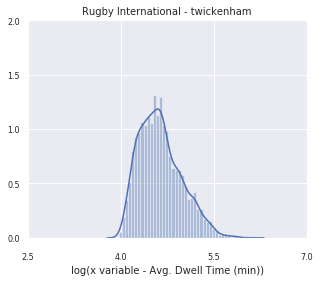

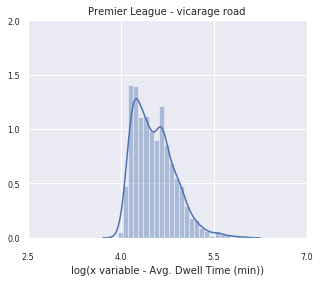

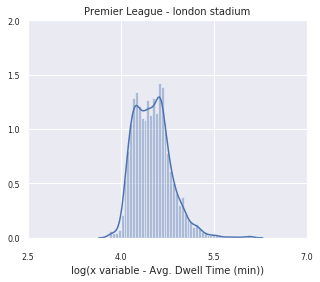

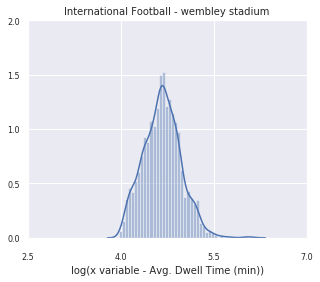

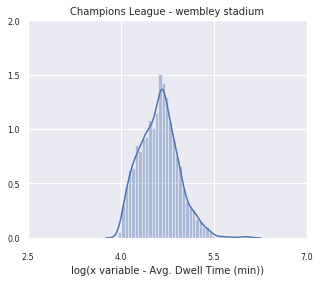

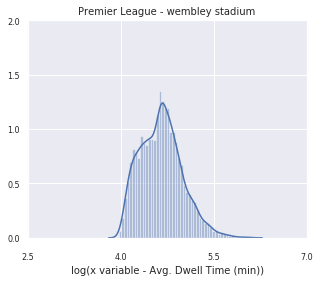

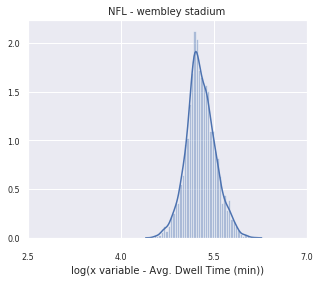

In [0]:
## For all different event
for i in venue_eventtype_list:
  
  new_data = data[data['venue_eventtype']==i].reset_index()
  eventname = new_data['venue_eventtype'][0]
  
  x = np.log(new_data['avg_dwelltime_min'])
  #x = new_data['avg_dwelltime_min']
  
  f, ax = plt.subplots(figsize=(5,4))
  
  sns.distplot(x)
  
  plt.title(str(eventname), fontsize=10, horizontalalignment='center')
  plt.xlabel('log(x variable - Avg. Dwell Time (min))',fontsize='10', horizontalalignment='center')
  plt.xticks(horizontalalignment='center', fontsize='8')
  plt.yticks(horizontalalignment='center', fontsize='8') 
  ax.set_xticks(np.arange(2.5,7.6,1.5))
  ax.set_yticks(np.arange(0,2.1,0.5))
  ax.tick_params(axis='both', which='major', pad=8)
 # plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/Avg_Dwelltime_Distribution/distplot_'+str(eventname)+'.png')
    
 # plt.close('all')
  plt.show()

#### Summary Statistic of the data

In [0]:
# summary statistic of the data.
data['log_avg_dwelltime_min'] = np.log(data['avg_dwelltime_min'])
data.groupby(['venue_eventtype']).describe()

avg_dwelltime_min  ... log_avg_dwelltime_min
                                                     count  ...                   max
venue_eventtype                                             ...                      
Champions League - wembley stadium                  3648.0  ...              6.070738
International Football - wembley stadium            3983.0  ...              6.155919
NFL - wembley stadium                               3626.0  ...              6.144186
Premier League - london stadium                     5859.0  ...              6.126869
Premier League - vicarage road                      1483.0  ...              6.007584
Premier League - wembley stadium                   13527.0  ...              6.124683
Rugby International - twickenham                    6464.0  ...              6.124683

[7 rows x 16 columns]



### TEST Statistical Assumption 
#### Levene Test - Homogeity of Variance



In [0]:
# Test for homgeity of variances

# Levene Test - If Test Significant : Homogeneity of variance is false

levene_test = []
event_list = []
for e in venue_eventtype_list:
  
  datanew = data[data['venue_eventtype']==e]
  data_nfl = data[data['venue_eventtype']=='Champions League - wembley stadium']
  
  test_levene = stats.levene(datanew['log_avg_dwelltime_min'],data_nfl['log_avg_dwelltime_min'])
  levene_test.append(test_levene)
  
  event_list.append(e)

In [0]:
# Levene Test
# Test assumption of normality. (First value w-test stat, Second value p-value)
## Levene Test Positive (Significant) -- Non-Homegenous Variance
## Levene Test Negative (Non-Significant) -- Homegenous Variance
 
new_df  =pd.DataFrame()

new_df['event'] = event_list
new_df['levene'] = levene_test

# Results -- p-value << 0.05 non-significant 
new_df

,event,levene
0,Rugby International - twickenham,"(37.69108531196229, 8.599642892052788e-10)"
1,Premier League - vicarage road,"(9.305445016768799, 0.0022964124080267173)"
2,Premier League - london stadium,"(6.840660641049378, 0.00892466606109376)"
3,International Football - wembley stadium,"(3.1150792695000504, 0.0776107077360247)"
4,Champions League - wembley stadium,"(0.0, 1.0)"
5,Premier League - wembley stadium,"(40.92675894385331, 1.6212803501755753e-10)"
6,NFL - wembley stadium,"(272.2264325995741, 4.541808149129114e-60)"


#### Shapiro - Test for Normal Distribution

(The plot distribution from log transform variable, already show normal distribution!)

In [0]:
# Shapiro t-test
## Shapiro Test Positive (Significant) -- Non-Normaly Distributed Data
## Shapiro Test Negative (Non-Significant) -- Normaly Distributed Data 

shapiro_test = []
test_shapiro_pvalue_list = []
event_list = []
for e in venue_eventtype_list:
  
  datanew = data[data['venue_eventtype']==e]
  
  test_shapiro = stats.shapiro(datanew['log_avg_dwelltime_min'])[0]
  test_shapiro_pvalue = stats.shapiro(datanew['log_avg_dwelltime_min'])[1]
  shapiro_test.append(test_shapiro)
  test_shapiro_pvalue_list.append(test_shapiro_pvalue)
  
  event_list.append(e)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [0]:
# Shapiro Test
# Test assumption of normality. (First value w-test stat, Second value p-value)

new_df  =pd.DataFrame()

new_df['Event Category'] = event_list
new_df['Shapiro test'] = shapiro_test
new_df['p-value'] = test_shapiro_pvalue_list

# Result - p-value << 0.05 True 
new_df

,Event Category,Shapiro test,p-value
0,Rugby International - twickenham,0.969611,6.916771e-35
1,Premier League - vicarage road,0.945768,6.301499e-23
2,Premier League - london stadium,0.962111,1.317307e-36
3,International Football - wembley stadium,0.989553,1.429507e-16
4,Champions League - wembley stadium,0.984110,7.825602e-20
5,Premier League - wembley stadium,0.982171,8.051567e-38
6,NFL - wembley stadium,0.996059,3.272752e-08


### ANOVA Test

In [0]:
# ANOVA Independent t-test

test = stats.f_oneway(data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Rugby International - twickenham'],
               data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Premier League - wembley stadium'],
               data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Premier League - vicarage road'],
               data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Premier League - london stadium'],
               data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'NFL - wembley stadium'],
               data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'International Football - wembley stadium'],
               data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Champions League - wembley stadium'])

print(test)
## p-value significant << 0.05
## F-statistic significant large!

F_onewayResult(statistic=2597.067210686205, pvalue=0.0)


In [0]:
results = ols('log_avg_dwelltime_min ~ C(venue_eventtype)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_avg_dwelltime_min   R-squared:                       0.288
Model:                               OLS   Adj. R-squared:                  0.288
Method:                    Least Squares   F-statistic:                     2597.
Date:                   Sat, 24 Aug 2019   Prob (F-statistic):               0.00
Time:                           10:42:57   Log-Likelihood:                -10623.
No. Observations:                  38590   AIC:                         2.126e+04
Df Residuals:                      38583   BIC:                         2.132e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          4.6197      0.005    875.558      0.000       4.609       4.630
C(venue_eventtype)[T.International Football - wembley stadium]     0.0520      0.007      7.115      0.000       0.038       0.066
C(venue_eventtype)[T.NFL - wembley stadium]                        0.6722      0.007     89.950      0.000       0.658       0.687
C(venue_eventtype)[T.Premier League - london stadium]             -0.1075      0.007    -15.993      0.000      -0.121      -0.094
C(venue_eventtype)[T.Premier League - vicarage road]              -0.0760      0.010     -7.741      0.000      -0.095      -0.057
C(venue_eventtype)[T.Premier League - wembley stadium]             0.0345      0.006      5.811      0.000       0.023       0.046
C(venue_eventtype)[T.Rugby International - twickenham]             0.0198      0.007      3.007      0.003       0.007       0.033
==============================================================================
Omnibus:                     1937.039   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2313.422
Skew:                           0.542   Prob(JB):                         0.00
Kurtosis:                       3.514   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
## Bonferroni Correction
## Calculate the corrected p-value 
## corrected p-value = p-value/# of comparisons = 0.05/(7 event_type)
print('Corrected p-value: '+str(0.05/7))

Corrected p-value: 0.0071428571428571435


#### Degree of Freedom

In [0]:
# Report the Degrees of Freedom. 

def ttest_twosamples(x, y): 
    ## T-Test Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    ttest_twosample = round(t,4)
    p_value = round(p,8)
    degfree = round(dof,4)
    
    return ttest_twosample, p_value, degfree

### Independent T-test

In [0]:
ttest_twosamples_list = []
p_value_list = []
degfree_list = []
event1_list = []
event2_list= []

for e in venue_eventtype_list:
  
#  print(' NFL v. '+str(e))
  nfl_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'NFL - wembley stadium'])
 # print(nfl_welch_ttest[])
  
  ttest_twosamples_list.append(nfl_welch_ttest[0])
  p_value_list.append(nfl_welch_ttest[1])
  degfree_list.append(nfl_welch_ttest[2])
  
  event1_list.append('NFL - Wembley')
  event2_list.append(e)
  
  
#  print(' Champions League v. '+str(e))
  chs_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Champions League - wembley stadium'])

  ttest_twosamples_list.append(chs_welch_ttest[0])
  p_value_list.append(chs_welch_ttest[1])
  degfree_list.append(chs_welch_ttest[2])
  
  event1_list.append('Champions League - wembley')
  event2_list.append(e)
  
 # print(' International Football WCQ v. '+str(e))
  if_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'International Football - wembley stadium'])

  ttest_twosamples_list.append(if_welch_ttest[0])
  p_value_list.append(if_welch_ttest[1])
  degfree_list.append(if_welch_ttest[2])
  
  event1_list.append('International Football WCQ - wembley')
  event2_list.append(e)
  
 # print(' Rugby v. '+str(e))
  rugby_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Rugby International - twickenham'])

  ttest_twosamples_list.append(rugby_welch_ttest[0])
  p_value_list.append(rugby_welch_ttest[1])
  degfree_list.append(rugby_welch_ttest[2])
  
  event1_list.append('Rugby - twickenham')
  event2_list.append(e)
  
 # print(' Watford v. '+str(e))
  plwa_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Premier League - vicarage road'])
  
  ttest_twosamples_list.append(plwa_welch_ttest[0])
  p_value_list.append(plwa_welch_ttest[1])
  degfree_list.append(plwa_welch_ttest[2])
  
  event1_list.append('Premier League - watford')
  event2_list.append(e)
  
#  print(' Wembley v. '+str(e))
  plwe_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Premier League - wembley stadium'])

  ttest_twosamples_list.append(plwe_welch_ttest[0])
  p_value_list.append(plwe_welch_ttest[1])
  degfree_list.append(plwe_welch_ttest[2])
  
  event1_list.append('Premier League - wembley')
  event2_list.append(e)
  
 # print(' London Stadium v. '+str(e)) 
  plls_welch_ttest = ttest_twosamples(data['log_avg_dwelltime_min'][data['venue_eventtype'] == e], 
                                            data['log_avg_dwelltime_min'][data['venue_eventtype'] == 'Premier League - london stadium'])
  
  ttest_twosamples_list.append(plls_welch_ttest[0])
  p_value_list.append(plls_welch_ttest[1])
  degfree_list.append(plls_welch_ttest[2])
  
  event1_list.append('Premier League - london stadium')
  event2_list.append(e)

In [0]:
ttest_twosamples_df = pd.DataFrame(list(zip(event2_list, event1_list,ttest_twosamples_list,p_value_list,degfree_list)), 
               columns =['Event Category 1', 'Event Category 2',"Independent t-test",'p-value','Degree of Freedom']) 

ttest_twosamples_df = ttest_twosamples_df[ttest_twosamples_df['p-value']!=1.0]
ttest_twosamples_df = ttest_twosamples_df.drop_duplicates(['p-value','Degree of Freedom']).reset_index(drop=True)

In [0]:
ttest_twosamples_df

,Event Category 1,Event Category 2,Independent t-test,p-value,Degree of Freedom
0,Rugby International - twickenham,NFL - Wembley,-113.7312,0.000000e+00,9737.9255
1,Rugby International - twickenham,Champions League - wembley,2.9714,2.973150e-03,8173.0838
2,Rugby International - twickenham,International Football WCQ - wembley,-5.0010,5.800000e-07,9181.0566
3,Rugby International - twickenham,Premier League - watford,10.0404,0.000000e+00,2275.3857
4,Rugby International - twickenham,Premier League - wembley,-2.8506,4.371270e-03,12648.3969
5,Rugby International - twickenham,Premier League - london stadium,22.0100,0.000000e+00,12308.7025
6,Premier League - vicarage road,NFL - Wembley,-79.8445,0.000000e+00,2109.1868
7,Premier League - vicarage road,Champions League - wembley,-7.6163,0.000000e+00,2614.1585
8,Premier League - vicarage road,International Football WCQ - wembley,-13.0475,0.000000e+00,2478.5310
9,Premier League - vicarage road,Premier League - wembley,-12.2416,0.000000e+00,1845.6040


### Mann-Whitney U-Test

In [0]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

# Mann-Whitney U-Test

mannwhitneyu_test = []
event_list = []
for e in venue_eventtype_list:
  
  datanew = data[data['venue_eventtype']==e]
  data_nfl = data[data['venue_eventtype']=='Champions League - wembley stadium']
  
  test_mannwhitneyu = mannwhitneyu(datanew['log_driving_dist_km'],data_nfl['log_driving_dist_km'])
  mannwhitneyu_test.append(test_mannwhitneyu)
  
  event_list.append(e)

In [0]:
# Mann-Whitney U-Test

new_df  =pd.DataFrame()

new_df['event'] = event_list
new_df['Mann-Whitney'] = mannwhitneyu_test

# Results -- p-value <<  significant - Samples are not equal !
new_df

,event,Mann-Whitney
0,Premier League - london stadium,"(2532447.5, 1.5217318192646258e-17)"
1,Rugby International - twickenham,"(3797676.5, 4.767869661443392e-07)"
2,Premier League - vicarage road,"(639586.0, 3.533053851490489e-19)"
3,Champions League - wembley stadium,"(2365312.5, 0.49999518366236034)"
4,International Football - wembley stadium,"(2393942.0, 0.0010912695552704403)"
5,NFL - wembley stadium,"(1831106.0, 7.690476248656086e-29)"
6,Premier League - wembley stadium,"(6569577.5, 0.4908156388223545)"
